In [203]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series, get_custom_data

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast

## Load Covid19india Data

In [205]:
dataframes = get_covid19india_api_data()

In [206]:
predictions_dict = {}

## Select Districts to fit on

In [207]:
districts_to_show = [('Maharashtra', 'Pune'), 
                     ('Maharashtra', 'Mumbai'), 
                     ('Rajasthan', 'Jaipur'), 
                     ('Gujarat', 'Ahmedabad'), 
                     ('Karnataka', 'Bengaluru Urban'),
                     ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Pune')]

## Perform M1 and M2 fits

In [210]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=True, initialisation='intermediate', num_evals=700,
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, num_evals=700,
                                                                     train_on_val=True, data_from_tracker=True, initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

fitting to data with "train_on_val" set to False ..


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
17  Maharashtra     Pune 2020-05-13        1770.8          3136.4     168.4   
18  Maharashtra     Pune 2020-05-14        1863.2          3308.0     174.4   
19  Maharashtra     Pune 2020-05-15        1963.8          3484.8     181.0   
20  Maharashtra     Pune 2020-05-16        2035.0          3666.8     189.2   
21  Maharashtra     Pune 2020-05-17        2084.6          3818.2     195.2   

    recovered  
17     1197.2  
18     1270.4  
19     1340.0  
20     1442.6  
21     1538.4  
val
          state district       date  hospitalised  total_infected  deceased  \
0  Maharashtra     Pune 2020-05-18        2188.8          4017.4     204.2   
1  Maharashtra     Pune 2020-05-19        2298.8          4221.0     213.4   
2  Maharashtra     Pune 2020-05-20        2438.2          4455.4     222.6   
3  Maharashtra     Pune 2020-05-21        2583.4          4710.6     

(Pdb)  l


 51  	        # Returning a very high loss value for the cases where the sampled values of P_severe and P_fatal are > 1
 52  	        if params_dict['P_severe'] + params_dict['P_fatal'] > 1:
 53  	            return 1e10                          
 54  	                                                 
 55  	        import pdb; pdb.set_trace()              
 56  ->	        solver = SEIR_Testing(**params_dict)   
 57  	        sol = solver.solve_ode(total_no_of_days=total_days - 1, time_step=1, method='Radau')
 58  	        df_prediction = solver.return_predictions(sol)
 59  	                                                 
 60  	        # Choose which indices to calculate loss on
 61  	        # TODO Add slicing capabilities on the basis of date
  0%|          | 0/700 [00:02<?, ?trial/s, best loss=?]

(Pdb)  n


> /home/users/sansiddh/projects/covid/covid-modelling/main/seir/optimiser.py(57)solve_and_compute_loss()
-> sol = solver.solve_ode(total_no_of_days=total_days - 1, time_step=1, method='Radau')
  0%|          | 0/700 [00:05<?, ?trial/s, best loss=?]

(Pdb)  solver


  0%|          | 0/700 [00:07<?, ?trial/s, best loss=?]

(Pdb)  sol


***                                                    
NameError: name 'sol' is not defined                   
  0%|          | 0/700 [00:09<?, ?trial/s, best loss=?]

(Pdb)  n


> /home/users/sansiddh/projects/covid/covid-modelling/main/seir/optimiser.py(58)solve_and_compute_loss()
-> df_prediction = solver.return_predictions(sol)
  0%|          | 0/700 [00:10<?, ?trial/s, best loss=?]

(Pdb)  sol


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 30
     njev: 1
      nlu: 8
      sol: None
   status: 0
  success: True
        t: array([0, 1, 2, 3, 4, 5, 6])
 t_events: None
        y: array([[9.99383252e-01, 9.99369436e-01, 9.99343420e-01, 9.99309392e-01,
        9.99270462e-01, 9.99228203e-01, 9.99183554e-01],
       [3.22919855e-04, 2.72932913e-04, 2.43403041e-04, 2.26901796e-04,
        2.17907507e-04, 2.13615846e-04, 2.12348079e-04],
       [1.80083712e-05, 6.96019427e-05, 1.02156580e-04, 1.22613304e-04,
        1.36131706e-04, 1.45332738e-04, 1.51785834e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.70343175e-06, 1.86488681e-05, 3.34157879e-05,
        4.92390784e-05, 6.52816506e-05, 8.1083545

(Pdb)  n


> /home/users/sansiddh/projects/covid/covid-modelling/main/seir/optimiser.py(62)solve_and_compute_loss()
-> if loss_indices == None:
  0%|          | 0/700 [00:30<?, ?trial/s, best loss=?]

(Pdb)  df_prediction


        date        S     E     I  D_E  D_I  R_mild  R_severe_home  \
0 2020-05-11  9993832  3229   180    0    0       0              0   
1 2020-05-12  9993694  2729   696    0    0      67              0   
2 2020-05-13  9993434  2434  1021    0    0     186              0   
3 2020-05-14  9993093  2269  1226    0    0     334              0   
4 2020-05-15  9992704  2179  1361    0    0     492              0   
5 2020-05-16  9992282  2136  1453    0    0     652              0   
6 2020-05-17  9991835  2123  1517    0    0     810              0   

   R_severe_hosp  R_fatal     C    D  hospitalised  recovered  deceased  \
0           1443      182   974  158          1625        974       158   
1           1450      182  1016  163          1632       1016       163   
2           1498      187  1067  169          1685       1067       169   
3           1571      196  1133  175          1767       1133       175   
4           1659      206  1215  181          1865       1215   

(Pdb)  q


job exception: 



  0%|          | 0/700 [00:41<?, ?trial/s, best loss=?]


BdbQuit: 

In [202]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, num_evals=1000,
                                                                     data_from_tracker=False, filename='../../data/data/official-pune-21-05-20.csv', 
                                                                     initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, num_evals=1000,
                                                                     data_from_tracker=False, filename='../../data/data/official-pune-21-05-20.csv',
                                                                     initialisation='intermediate', train_on_val=True, 
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

fitting to data with "train_on_val" set to False ..
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
16 2020-05-07  Maharashtra     Pune          2148.6        1352.4      670.2   
17 2020-05-08  Maharashtra     Pune          2256.4        1356.6      767.2   
18 2020-05-09  Maharashtra     Pune          2365.2        1358.8      867.6   
19 2020-05-10  Maharashtra     Pune          2483.4        1363.2      975.2   
20 2020-05-11  Maharashtra     Pune          2599.2        1344.6     1104.2   

    deceased  
16     126.0  
17     132.6  
18     138.8  
19     145.0  
20     150.4  
val
         date        state district  total_infected  hospitalised  recovered  \
0 2020-05-12  Maharashtra     Pune          2720.6        1328.2     1236.2   
1 2020-05-13  Maharashtra     Pune          2842.8        1322.4     1358.2   
2 2020-05-14  Maharashtra     Pune          2987.2        1337.8     1480.0   
3 2020-05-15 

KeyboardInterrupt: 

In [175]:
predictions_dict[('Maharashtra', 'Mumbai')]['m1'].keys()

dict_keys(['best_params', 'default_params', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'ax', 'trials'])

## Create Master Loss Dataframe

### M1 Loss

In [138]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                            hospitalised total_infected deceased recovered   
Maharashtra Mumbai                  2.07           1.13     1.93      6.38   
            Pune                   11.79           7.67     1.61      5.04   
Rajasthan   Jaipur                  6.42           0.91     4.26      4.91   
Gujarat     Ahmedabad               0.97           0.56     2.73      2.13   
Karnataka   Bengaluru Urban         3.19           1.49        0       2.3   
Delhi       NaN                     1.75           1.23      1.7      4.15   

                                     val                                    
                            hospitalised total_infected deceased recovered  
Maharashtra Mumbai                  1.28           1.92     2.11      7.77  
            Pune                    3.18           0.95     12.1      6.11  
Rajasthan   Jaipur                 26.94            6.1    19.99     16.31  
Gujarat     Ahmedabad               6.12           3.22    12.96      5.52  
Karnataka   Bengaluru Urban         3.93           3.17     3.57      4.12  
Delhi       NaN                    11.66           5.84    34.15      9.35

### M2 Loss

In [44]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai         2.07           1.05     0.73      9.54

## Plot Forecasts

getting forecasts ..
getting forecasts ..


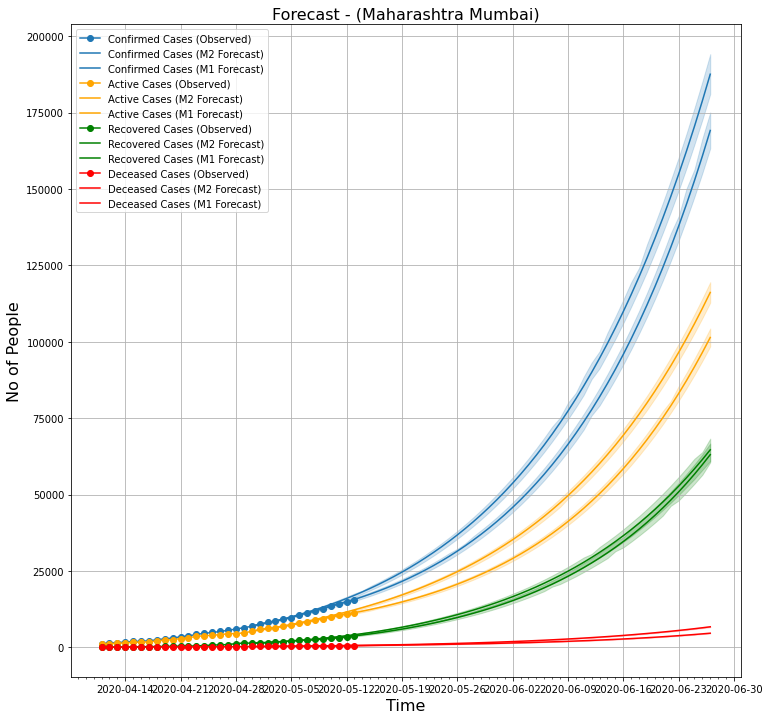

In [184]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=False,)

## Create and Save Output CSV

In [85]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [88]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))